# Predicting Protein–Ligand Binding with AlphaFold 3: A Step-by-Step Example


AlphaFold 3 extends AlphaFold 2 by natively supporting ligands, nucleic acids, and ions, making it a powerful tool for modeling biomolecular interactions relevant to drug discovery.  This tutorial demonstrates how to use AlphaFold 3 to predict a protein–ligand complex, using the well-characterized structure [1ATP](https://www.rcsb.org/structure/1ATP) as an example. We draw input data from the Protein Data Bank, including the UniProt sequence [P05132](https://www.uniprot.org/uniprotkb/P05132) for the protein and [ATP](https://www.rcsb.org/ligand/ATP) as the ligand.


## Overview

- Protein: PKA catalytic subunit (UniProt ID: P05132)
- Ligand: ATP
- Goal: Use AlphaFold 3 to predict the ligand-bound structure with minimal input, and compare the result to the experimental reference 1ATP from the Protein Data Bank (PDB).

## Running AlphaFold 3

We use the [AlphaFold 3 Server](https://alphafoldserver.com/) to predict the interaction between the protein and ligand. The server provides a convenient web interface that supports standard proteins and ligands defined by CCD codes (e.g., ATP), allowing users to quickly model biologically relevant complexes without any local setup. This makes it ideal for exploratory use and small-scale structure prediction.

However, the server has several limitations:

* It does not support custom ligands defined by SMILES, MOL2, or PDB fragments.
* Ligands must be specified using a restricted set of predefined CCD codes.
* Users have no control over MSA generation, template selection, or model sampling.

For more advanced use cases—such as incorporating non-standard ligands, adjusting MSAs, or running multiple seeds—we discuss how to run AlphaFold 3 locally in the subsequent tutorial.



### Getting the Protein Sequence

1. Visit the [UniProt page for P05132](https://www.uniprot.org/uniprotkb/P05132/entry).
2. Click the **Download** button to open the download options.
3. Set **Dataset** to `entry` and **Format** to `FASTA (canonical)`.
4. Click **Preview** to display the sequence.
5. Copy the sequence starting from the **second line**, skipping the header.

### Python packages: 

This notebook requires the following Python packages: pandas, matplotlib, and biopython

```python
!pip install pandas matplotlib biopython
```

### Server Interface

1. Set the first **Entity Type** to **Protein** and **Copies** to **1**, then paste the P05132 FASTA sequence into the input box.
2. Set the second **Entity Type** to **Ligand** and **Copies** to **1**, then select **ATP** from the list.
3. Click the three dots to reveal **Template Settings**, and leave it as the default:
  *“Use PDB templates with default cut-off date (30/09/2021)”*
4. Click **Continue and preview job**, then **Confirm and submit job**

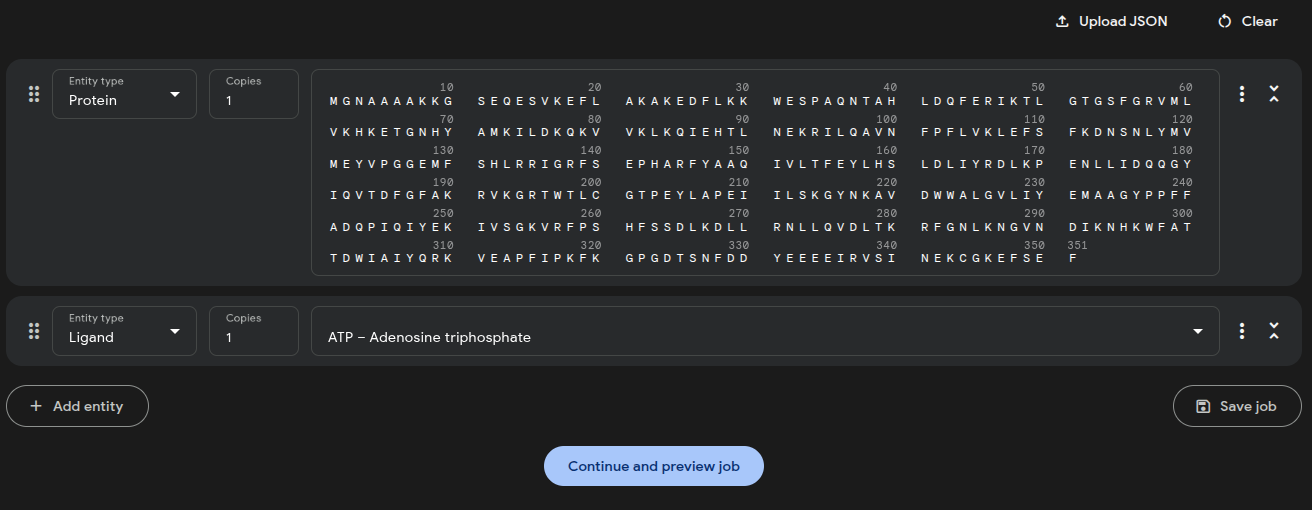

In [3]:
#  Show input interface
from IPython.display import Image, display
display(Image(filename="../images/server_setup.png", width=1000))  

Once the run is complete, click the job name to view the results.

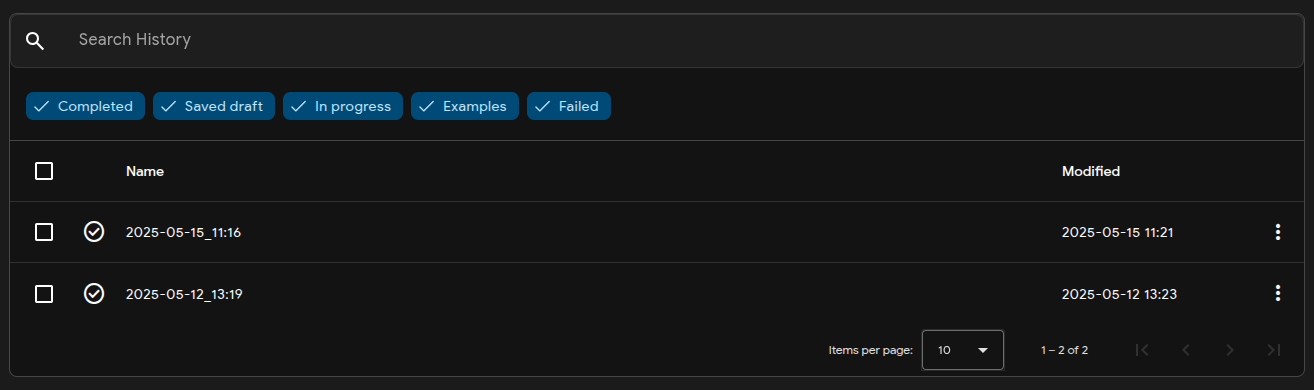

In [4]:
#  Show job interface
from IPython.display import Image, display
display(Image(filename="../images/runs.png", width=1000)) 

### Results

* **Left panel:** The predicted 3D structure is colored by per-residue pLDDT confidence values.
  Interpretation of pLDDT scores:

  * `>90`: very high confidence (typically well-placed backbone and side chains)
  * `70–90`: generally reliable
  * `50–70`: low confidence, possibly flexible or disordered regions
  * `<50`: likely disordered or unreliable

  The consistently high pLDDT scores, mostly above 90, indicate strong confidence in the predicted structure.

* **Right panel:** The predicted aligned error (PAE) is shown as a 2D heatmap.
  The overall low PAE values further support confidence in the relative positioning of residues and domains.



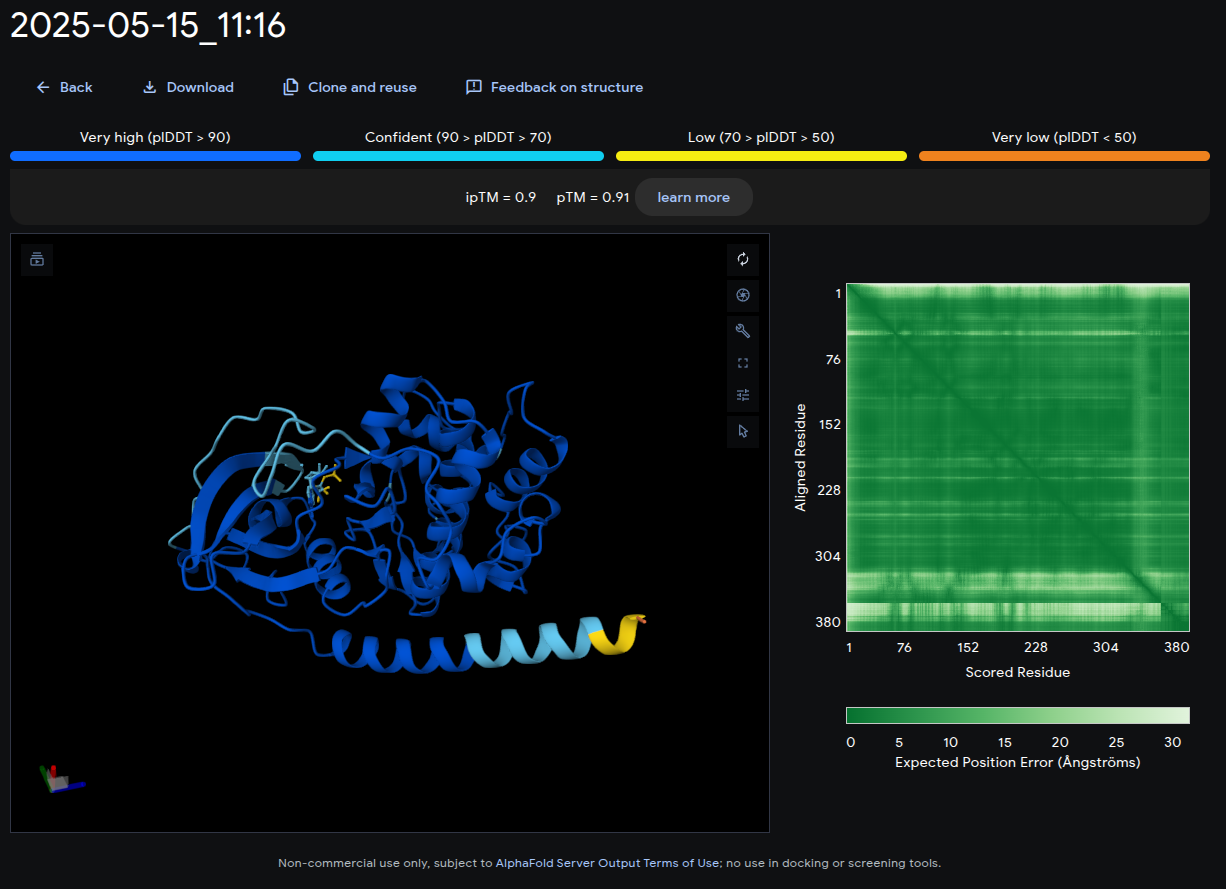

In [2]:
#  Show input interface
from IPython.display import Image, display
display(Image(filename="../images/results.png", width=1000)) 

Predicted local Distance Difference Test (pLDDT)

In AlphaFold (both versions 2 and 3), pLDDT is trained to approximate lDDT-Cα, a per residue meetric that reflects local structural accuracy with respect to a reference. Conceptually, [lDDT(i)-Cα](https://swissmodel.expasy.org/lddt) is the fraction of neighboring residues $j$ (within a cutoff) for which the predicted Cα–Cα distances agree with the true distance within a set of predefined thresholds. 
$$
\text{lDDT}(i) = \frac{1}{N_i} \sum_{j \in \mathcal{N}_i} \frac{1}{4} \sum_{\delta \in \{0.5, 1.0, 2.0, 4.0\}} \mathbb{I} \left( \left| d_{ij}^{\text{pred}} - d_{ij}^{\text{true}} \right| < \delta \right)
$$
where 
- $N_i$ is the set of neighbors of residue $i$ within a certain tolerance in the reference structure,
- $d^\text{pred}_{ij}$, $d^\text{true}_{ij}$ distances between residues $i$ and $j$ in predicted and reference structures,
- $\mathbb{I}$ indicator function,
- and $\delta$ include different thresholds.
  
lDDT-Cα is computed without requiring structural alignment and measures how well local geometry is preserved. For further details, see Section 1.9.6 of [AlphaFold3 Method Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03819-2/MediaObjects/41586_2021_3819_MOESM1_ESM.pdf) and section 2.1 of the original [IDDT paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC3799472/pdf/btt473.pdf)

[Predicted Aligned Error (PAE)](https://alphafold.ebi.ac.uk/faq)

The green shading at each point $(i, j)$ on the PAE heatmap represents AlphaFold’s predicted positional error at residue $i$ (the scored residue), assuming the structure is aligned on residue $j$ (the reference residue).
- A consistently green (low PAE) block between two domains indicates that AlphaFold is confident in their relative position and orientation.
- If the PAE values are high, the spatial relationship between those domains is uncertain and should be interpreted with caution.

Conceptually, PAE can be thought of as:
$$
\text{PAE}(i, j) = \text{E}[T_j(r^\text{pred}_i),r^\text{true}_i)]
$$

where $r_j^\text{true}$ and $r_j^\text{pred}$ are the predicted and true positions of residue $i$. $T_j$ is the transformation that aligns the predicted structure to the reference (true) structure, using residue $j$ as the alignment anchor. Residue $j$ in the predicted structure is aligned to its position in the true structure, and the positional error is then evaluated for another residue $i$.The model learns to predict this expected alignment error directly, without access to the true structure.   

### Visualization

We’ll use ChimeraX to visualize and compare the predicted structure with the reference. It’s a powerful tool for viewing, aligning, and analyzing 3D molecular structures, including proteins and ligands. Installation is straightforward, simply follow the instructions on the [UCSF ChimeraX download](https://www.cgl.ucsf.edu/chimerax/download.html) page. You can also explore [official ChimeraX tutorials](https://www.rbvi.ucsf.edu/chimerax/tutorials.html) and [User Guide](https://www.cgl.ucsf.edu/chimerax/docs/user/index.html#commands) for guidance.

To open the predicted structure from the ChimeraX command line, run:

`open ../data/server_output/fold_2025_05_15_11_16_model_0.cif`

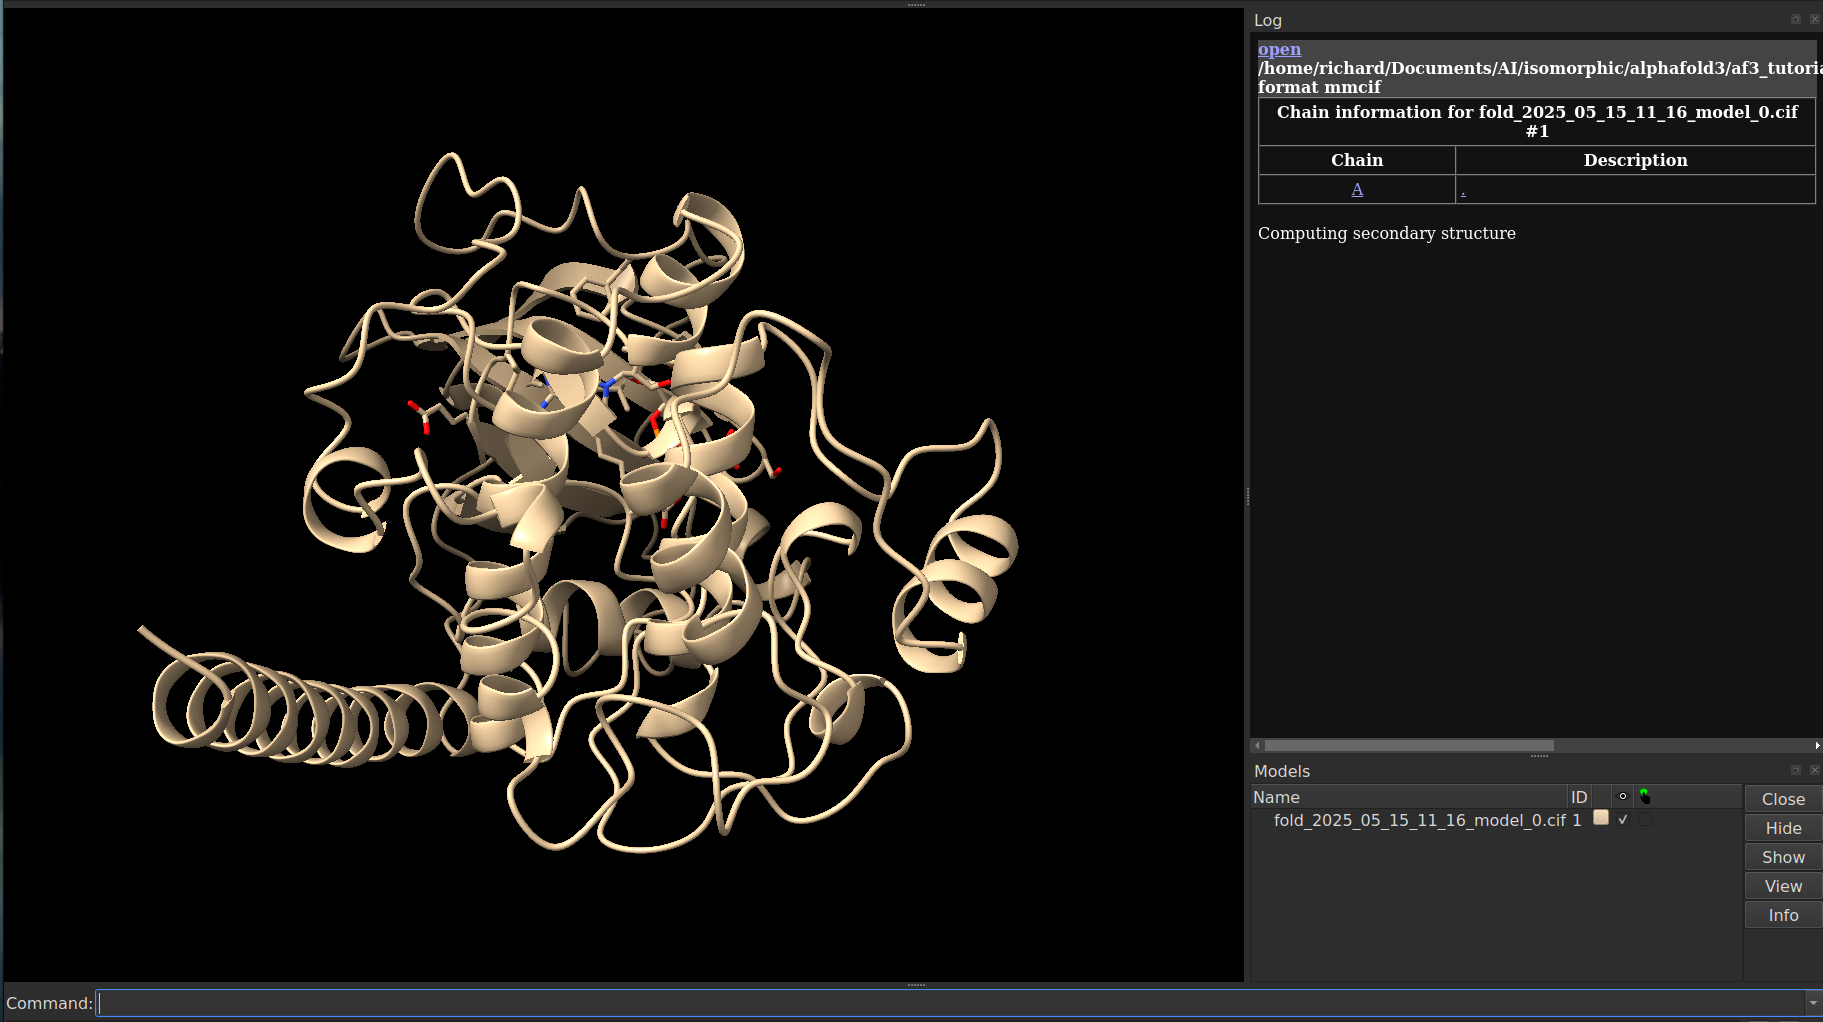

In [3]:
#  Show predicted structure
from IPython.display import Image, display
display(Image(filename="../images/predicted_structure.png", width=1000))

To load the reference structure from the Protein Data Bank, run

`open 1ATP`

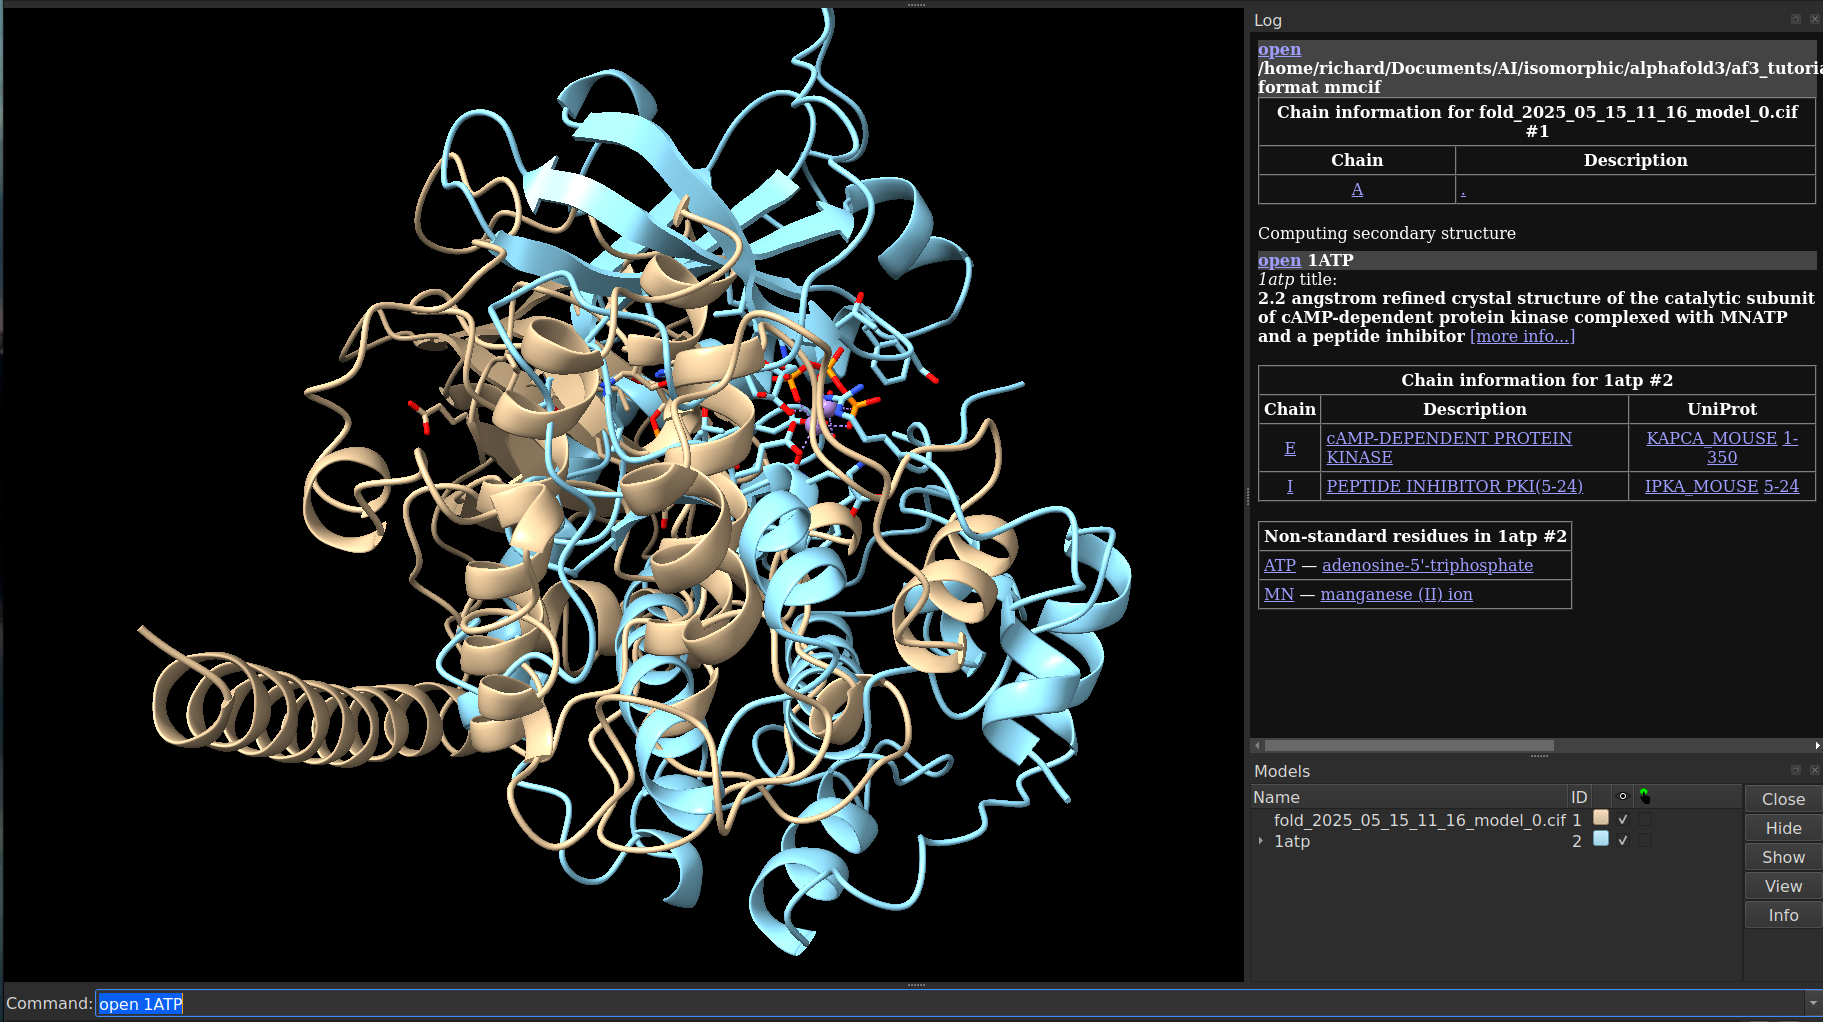

In [12]:
#  add reference structure
from IPython.display import Image, display
display(Image(filename="../images/predicted_and_reference_structure.png", width=1000))

Both the predicted structure and the experimental structure from the PDB are now displayed in the viewer.  To align the proteins of the predicted structure with the reference structure, run

`matchmaker #1/A: to #2/E`

Note that the protein chain for predicted structure is labeled as A, and the reference structure is labeled as E

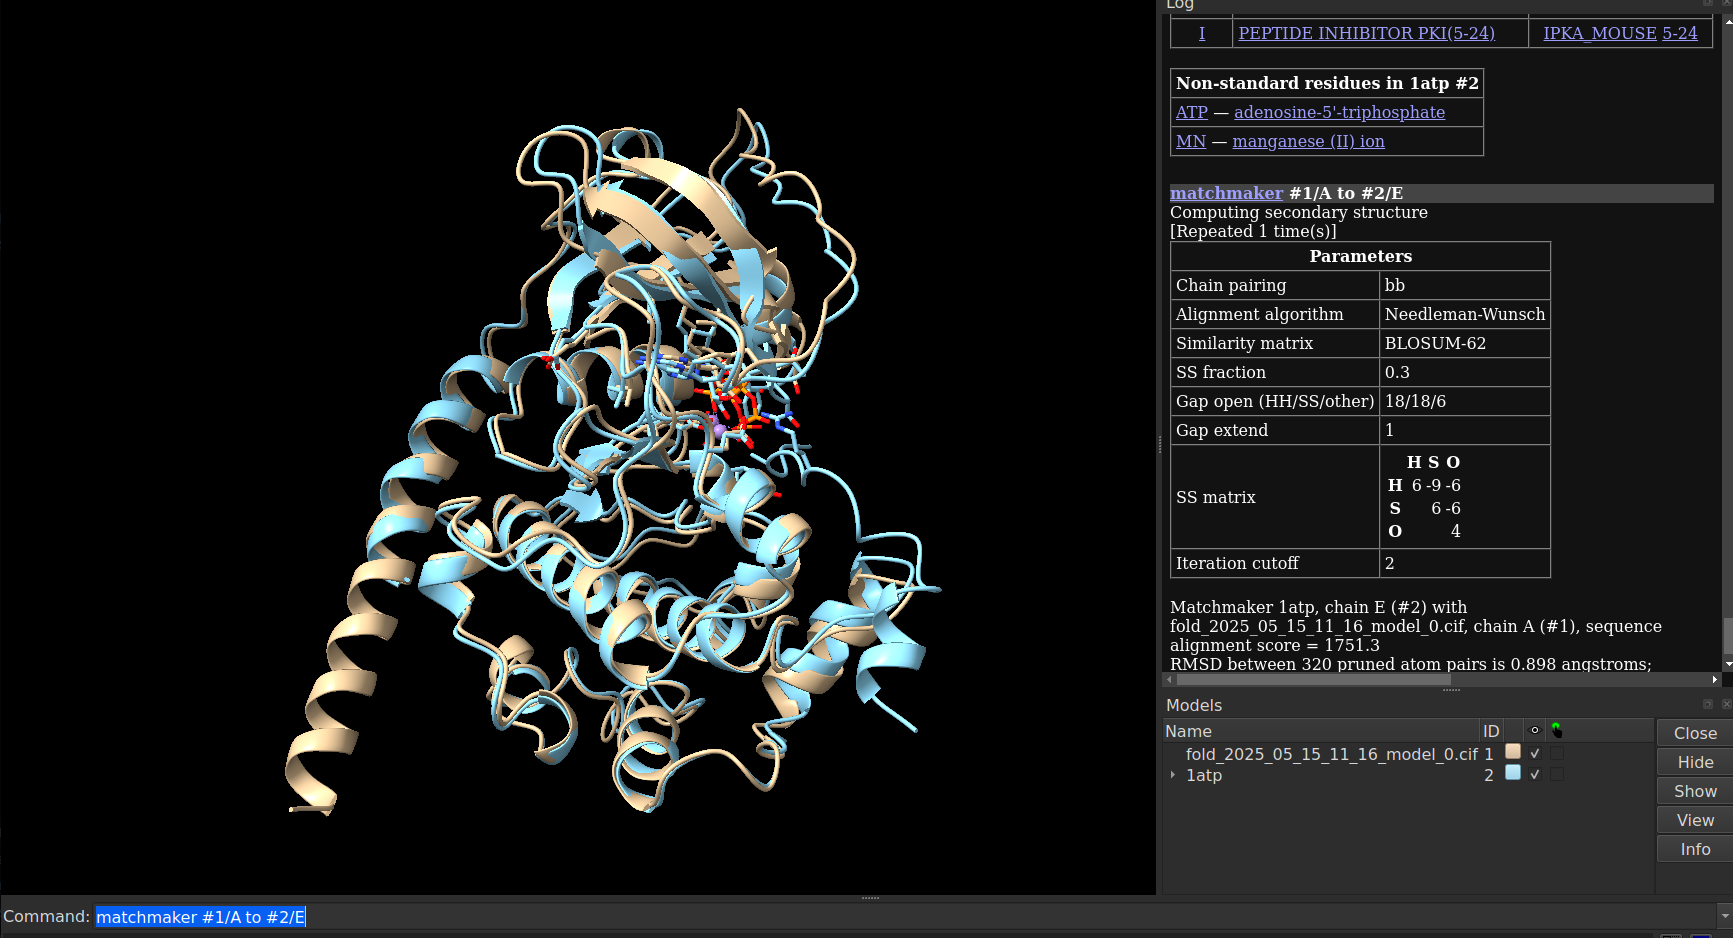

In [3]:
#  Show input interface
from IPython.display import Image, display
display(Image(filename="../images/matchmaker.png", width=1000))

From the visualization, it’s clear that the predicted structure aligns well with the 1ATP reference structure from the PDB. `matchmaker` also reports Cα RMSD in the log panel, which quantifies the difference between two 3D structures. Cα RMSD is defined as the root mean square distance of Cα for each residue between the strucutres:


$$
 \text{RMSD} = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \|\mathbf{x}_i - \mathbf{y}_i\|^2}  
$$

where N is the number of matched atoms and $x_i$ and $y_i$ are the positions of atom $i$ in the predicted and reference structures after alignment. A protein RMSD of 0.898 Å reflects high structural agreement with the reference, confirming the accuracy of the predicted fold.

Ligands

To zoom in on the ATP ligand, use: 

`view #1 &:ATP`

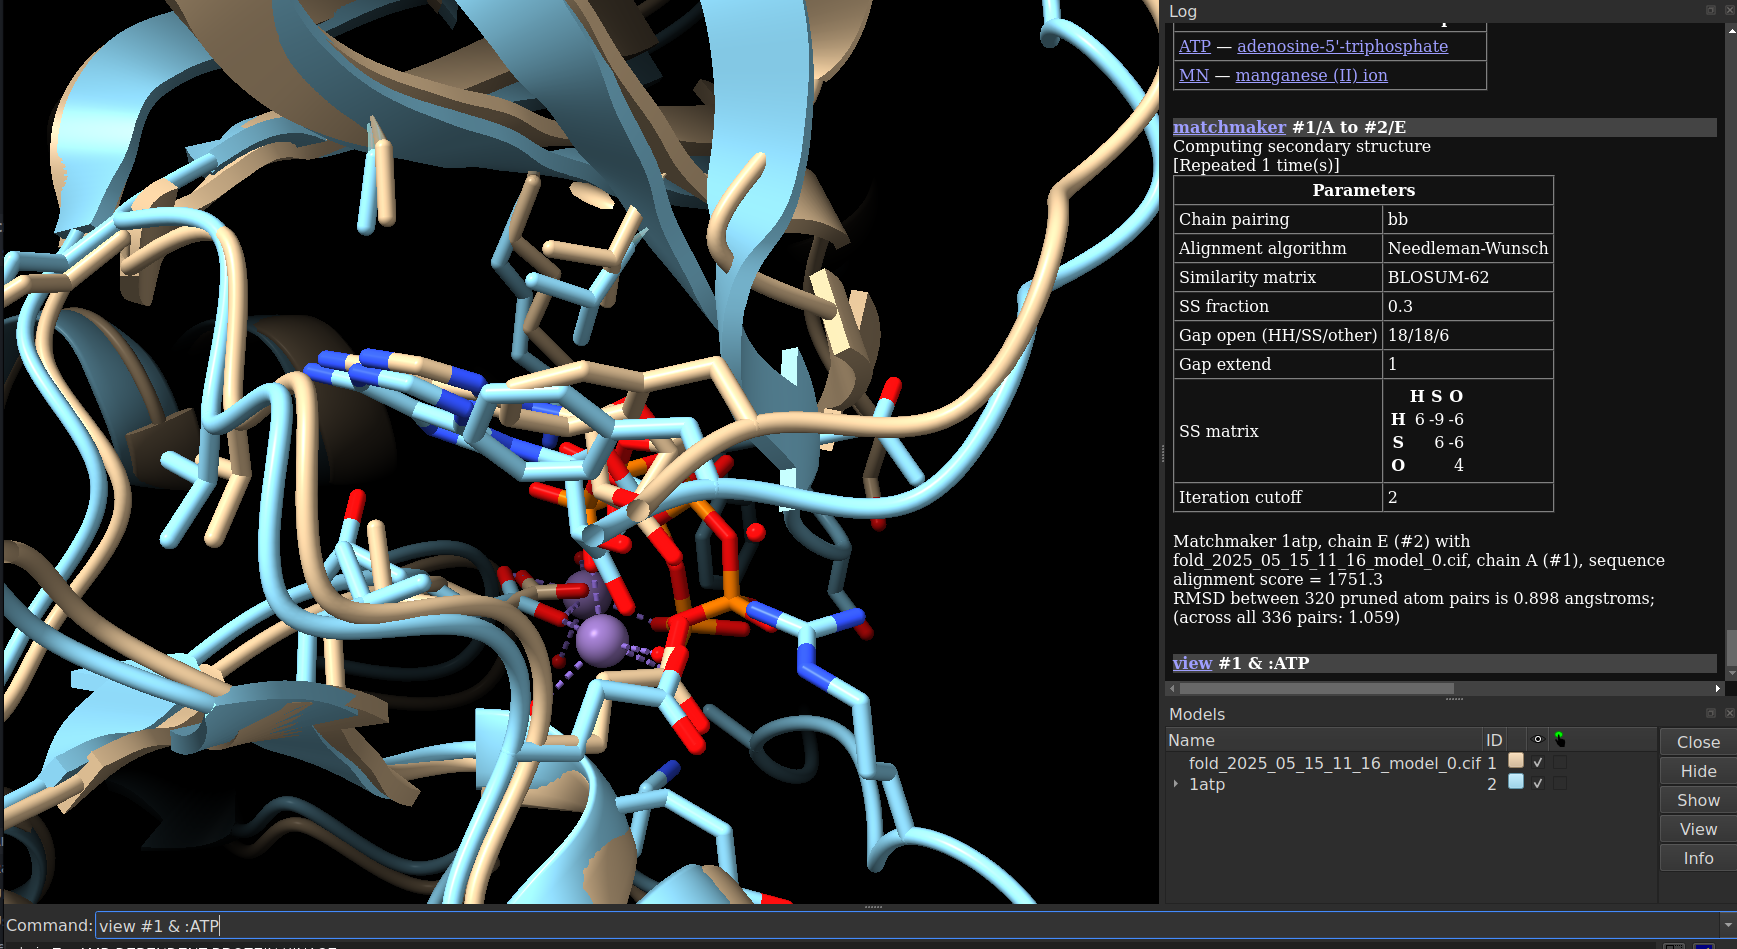

In [17]:
#  zoom in ATP
from IPython.display import Image, display
display(Image(filename="../images/ligands.png", width=1000)) 

To show ATP only in predicted and reference structure, run:

- `hide cartoons`
- `hide #1`
- `hide #2`
- `show #1 & :ATP`
- `show #2 & :ATP`



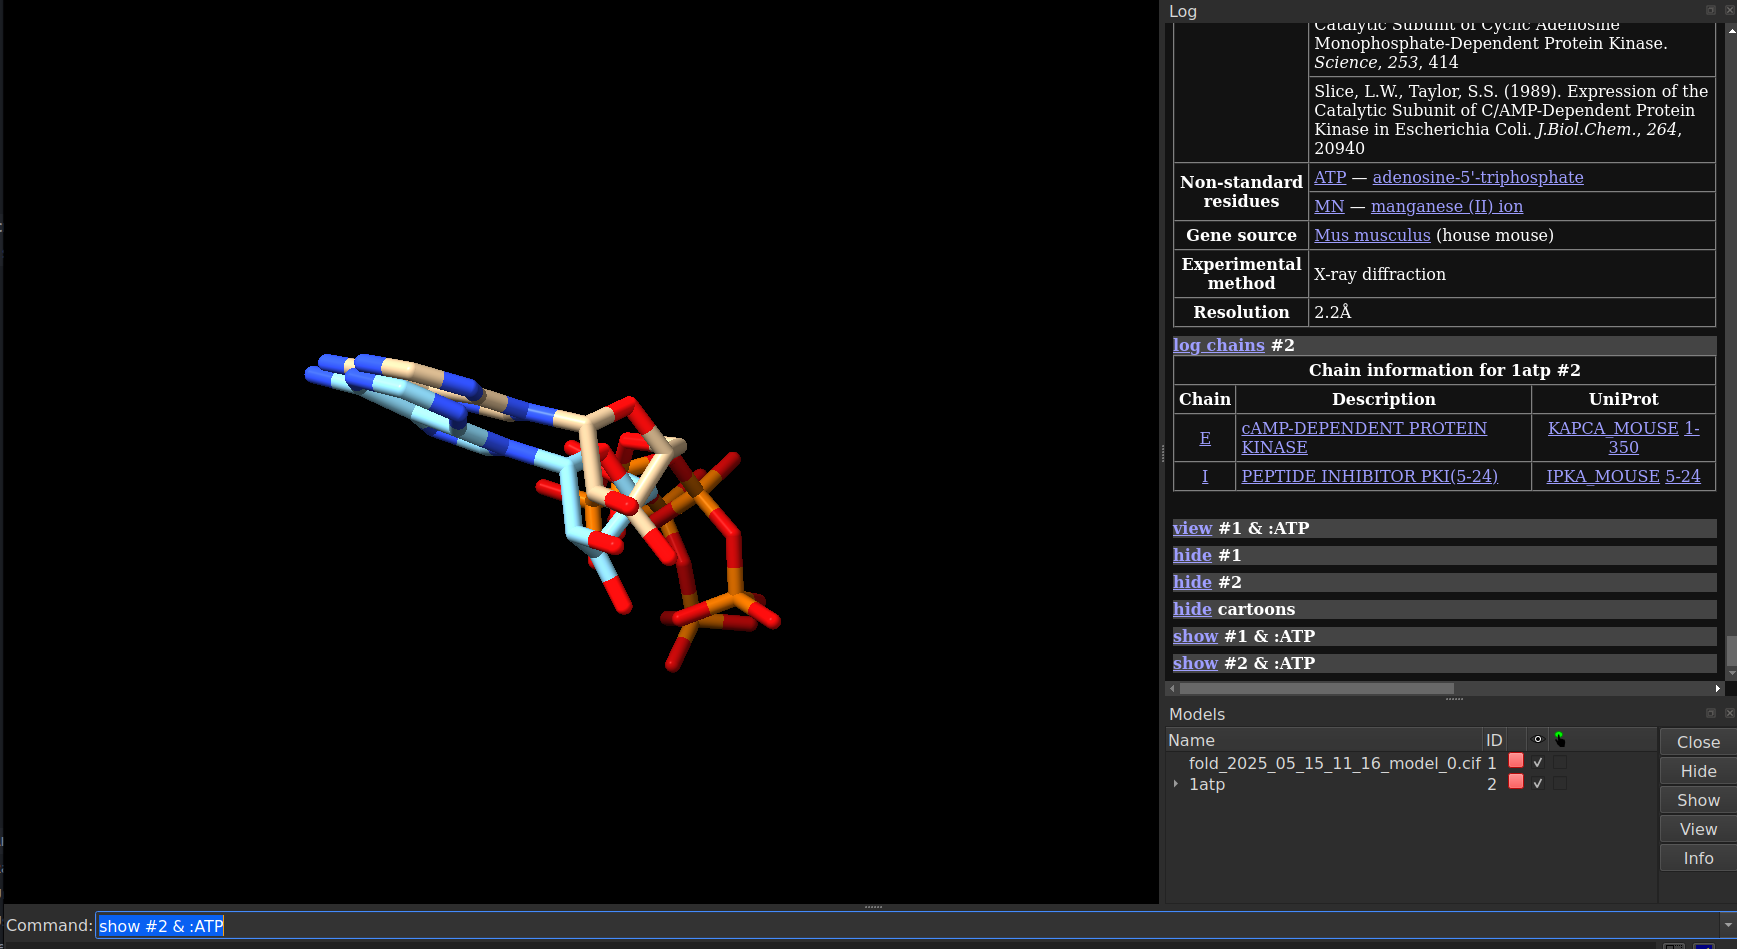

In [19]:
#  Show ligands
from IPython.display import Image, display
display(Image(filename="../images/ATP.png", width=1000)) 

RMSD for ATP
To assess how accurately the ATP ligand was placed in the predicted structure, you can compute the RMSD between the predicted and reference ATP molecules using:

`rmsd #1 & :ATP to #2 & :ATP`

The resulting RMSD is 1.469 Å, indicating that the predicted ligand pose closely matches the experimentally determined structure. This level of agreement suggests a fairly accurate binding prediction.

### Other confidence scores
Like AlphaFold2, AlphaFold3 provides additional confidence scores, including the predicted template modeling score (pTM) and the interfacial pTM score (ipTM). These metrics will be discussed in a subsequent tutorial.


In [1]:
## show summary confidences
from utils import load_json_file, display_scores_as_dataframes

summary = load_json_file("../data/server_output/fold_2025_05_15_11_16_summary_confidences_0.json")
display_scores_as_dataframes(summary)  # displays scores in 2x2 layout

## Conclusion

In this tutorial, we walked through a step-by-step run of the AlphaFold 3 server and used ChimeraX to visualize the close agreement between the predicted structure and the experimental reference. We also zoomed in on the ATP binding site and computed the ligand RMSD, demonstrating that the AF3 server can produce accurate and meaningful predictions.

As noted earlier, the server has limitations — including a restricted set of supported CCD codes and limited input flexibility. For example, structures involving custom ligands such as YQG in PDB ID 7M41 cannot be run on the AlphaFold 3 server.

To model such systems, AlphaFold 3 must be run locally. In the next tutorial, we’ll cover how to install and run AlphaFold 3 locally, using 7M41 with ligand YQG as a case study.